In [45]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Lecture 18 – Causality and Bootstrapping

## DSC 10, Spring 2022

### Announcements

- Homework 5 is due **Sat at 11:59pm**.
- Lab 6 is due **Tue at 11:59pm**.

### Agenda

- Using permutation tests to show causality.
- Bootstrapping.

## Causality example: chronic back pain

### Permutation testing (a.k.a. A/B testing)
- Given two samples, are they drawn from the same population?
- We can use permutation tests to answer questions like:
    - "Do smoking moms and nonsmoking moms have babies that weigh the same?"
    - "Were COVID-19 rates the same in Republican states and Democratic states?"
    - **More generally:** are *these things* like *those things*?

### Causality and permutation tests

- Permutation tests can be used to establish **causality** in a randomized control trial!
- If the only difference between two groups is that one was given the treatment, and there is a statistically significant difference between the two groups, then we can conclude the treatment had some effect.

### Using Botulinum toxin A (Botox) to treat lower back pain


> [Botulinum neurotoxins (BoNTs) are the most potent toxins known.](https://febs.onlinelibrary.wiley.com/doi/10.1002/1873-3468.13446)

- Botox is commonly used for treating muscle disorders, migraines, and for cosmetic purposes.
- A randomized controlled trial examined the use of Botox in the treatment of lower back pain.
    - 31 patients with pain were randomly assigned to control and treatment groups.
    - The control group received a placebo (saline injection).
        - Placebos are used when we don't want individuals to know which group they are in.
    - The treatment group received Botox.
    - After eight weeks, the number of people who experienced relief in both groups was counted.

### The data

- 1 means "experienced relief".
- 0 means "no relief".

In [16]:
back = bpd.read_csv('data/bta.csv')
back

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0
...,...,...
26,Treatment,0.0
27,Treatment,0.0
28,Treatment,0.0
29,Treatment,0.0


In [17]:
back.groupby('Group').count()

,Result
Group,
Control,16
Treatment,15


### The results

In [18]:
# This evaluates to the proportion experiencing relief in each group
back.groupby('Group').mean()

,Result
Group,
Control,0.125
Treatment,0.600


- 60% of the treatment group experienced relief, compared to 12.5% of the control group.
- But what if the people in the treatment group would have gotten better without the treatment, by chance?
    - If this were the case, then the treatment would look like it had an impact even if it didn't.
    - To account for this possibility, we should conduct a hypothesis test.

### A permutation test

- Here, we have two numerical samples – the results for the control group, and the results for the treatment group.
- **Null hypothesis**: Results for both groups come from the same distribution. 
    - In other words, Botox does not do anything different than saline, and the results we saw are due to chance. 
- **Alternative hypothesis**: More people in the treatment group experience relief.
    - In other words, Botox helped with relief more than saline.
- **Test statistic**: difference in proportion experiencing relief.

In [19]:
# This will work whether the column is 'Result' or 'ShuffledResult'
def difference_in_relief(df, column):
    grouped = df.groupby('Group').mean().get(column)
    return grouped.loc['Treatment'] - grouped.loc['Control']

In [20]:
observed_difference = difference_in_relief(back, 'Result')
observed_difference

0.475

### Shuffling

In [21]:
shuffled_results = np.random.permutation(back.get('Result'))
shuffled = back.assign(ShuffledResult=shuffled_results)
shuffled

,Group,Result,ShuffledResult
0,Control,1.0,1.0
1,Control,1.0,1.0
2,Control,0.0,1.0
3,Control,0.0,0.0
4,Control,0.0,1.0
...,...,...,...
26,Treatment,0.0,0.0
27,Treatment,0.0,1.0
28,Treatment,0.0,1.0
29,Treatment,0.0,0.0


- The above DataFrame contains the results of one "shuffling" of the data.
- This is equivalent to taking all participants in the trial and randomly assigning 16 to the control group and 15 to the treatment group.
    - The same effect could be achieved by shuffling the `'Group'` column instead.

### The simulation

In [22]:
np.random.seed(4242) # Magic to ensure that we get the same results every time this code is run. 

n_repetitions = 500
differences = np.array([])

for i in np.arange(n_repetitions):
    # Step 1: Shuffle the results
    shuffled_results = np.random.permutation(back.get('Result'))
    
    # Step 2: Put the shuffled results in a DataFrame
    shuffled = back.assign(ShuffledResult=shuffled_results)
    
    # Step 3: Compute the difference in group proportions and add the result to the differences array
    difference = difference_in_relief(shuffled, 'ShuffledResult')
    
    differences = np.append(differences, difference)

### Visualization

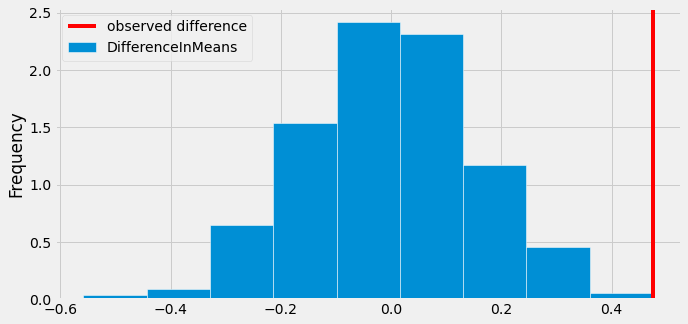

In [23]:
bpd.DataFrame().assign(DifferenceInMeans=differences).plot(kind='hist', bins=9, density=True, ec='w', figsize=(10, 5));
plt.axvline(observed_difference, color='red', label='observed difference')
plt.legend();

The p-value is the probability of seeing a test statistic equal to the observed test statistic or more extreme in the direction of the alternative hypothesis, under the null hypothesis.

In [24]:
# p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

0.006

This is saying that the probability of seeing results this different in the two groups due to chance alone is vanishingly small (close to 0).

### Conclusion

- We reject the null hypothesis with a high degree of confidence.
- This is evidence that the treatment **caused** improvement.
    - **Only because** this was a **randomized controlled trial**.
    - In earlier examples (e.g. birth weights of babies from smoking moms and nonsmoking moms), we could not establish causality because there could have been other differences between the two groups.
- Read more about this example in [CIT 12.2](https://inferentialthinking.com/chapters/12/2/Causality.html?highlight=randomized%20control#potential-outcomes).

## Bootstrapping 🥾

### City of San Diego employee salary data

All City of San Diego employee salary data [is public](https://publicpay.ca.gov/Reports/Cities/City.aspx?entityid=405&year=2020&rpt=1). We are using the latest available data.

In [25]:
population = bpd.read_csv('data/2020_salaries.csv')
population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,Position,ElectedOfficial,Judicial,OtherPositions,MinPositionSalary,MaxPositionSalary,...,HealthDentalVision,TotalRetirementAndHealthContribution,PensionFormula,EmployerURL,EmployerPopulation,LastUpdatedDate,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
0,2020,City,San Diego,Police,Police Sergeant,False,False,NaN,97718,118123,...,16700,31795,3.0% @ 50,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
1,2020,City,San Diego,Police,Police Sergeant,False,False,NaN,97718,118123,...,16403,36380,3.0% @ 50,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
2,2020,City,San Diego,Retirement,Retirement Administrator,False,False,NaN,77917,311168,...,0,24792,NaN,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
3,2020,City,San Diego,Fire-Rescue,Fire Engineer,False,False,NaN,65728,79456,...,19313,38362,3.0% @ 50,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
4,2020,City,San Diego,Fire-Rescue,Fire Battalion Chief,False,False,NaN,88275,106829,...,15689,25541,3.0% @ 50,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12599,2020,City,San Diego,Development Services,Asst Eng.-Civil,False,False,NaN,61755,74402,...,0,0,NaN,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
12600,2020,City,San Diego,Police,Police Officer 2,False,False,NaN,80517,97302,...,0,0,NaN,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
12601,2020,City,San Diego,Engineering & Capital Projects,Project Officer 1,False,False,NaN,71094,85862,...,0,0,NaN,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN
12602,2020,City,San Diego,Planning,Asst Planner,False,False,NaN,59114,71531,...,0,0,NaN,www.sandiego.gov,1411034,06/29/2021,San Diego,NaN,False,NaN


When you load in a dataset that has so many columns that you can't see them all, it's a good idea to look at the column names.

In [26]:
population.columns

Index(['Year', 'EmployerType', 'EmployerName', 'DepartmentOrSubdivision',
       'Position', 'ElectedOfficial', 'Judicial', 'OtherPositions',
       'MinPositionSalary', 'MaxPositionSalary', 'ReportedBaseWage',
       'RegularPay', 'OvertimePay', 'LumpSumPay', 'OtherPay', 'TotalWages',
       'DefinedBenefitPlanContribution', 'EmployeesRetirementCostCovered',
       'DeferredCompensationPlan', 'HealthDentalVision',
       'TotalRetirementAndHealthContribution', 'PensionFormula', 'EmployerURL',
       'EmployerPopulation', 'LastUpdatedDate', 'EmployerCounty',
       'SpecialDistrictActivities', 'IncludesUnfundedLiability',
       'SpecialDistrictType'],
      dtype='object')

### We only need the total wages...

In [27]:
population = population.get(['TotalWages'])
population

,TotalWages
0,320699
1,318312
2,317814
3,309281
4,307417
...,...
12599,2
12600,2
12601,1
12602,1


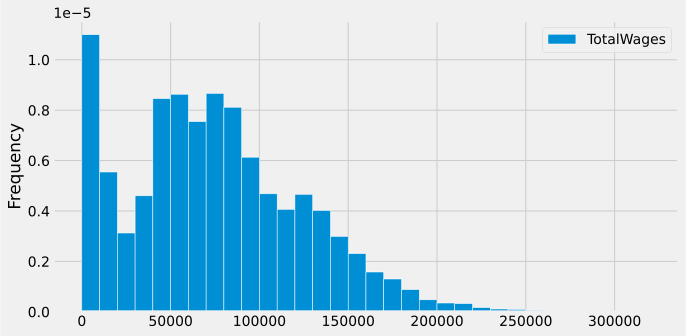

In [47]:
population.plot(kind='hist', bins=np.arange(0, 325000, 10000), density=True, ec='w', figsize=(10, 5));

### The median salary

- We can use `.median()` to find the median salary of all city employees.
- This is **not** a random quantity.

In [29]:
population_median = population.get('TotalWages').median()
population_median

71354.5

### But now...

- ...suppose we don't have access to this entire dataset.
- In practice, it is costly and time-consuming to survey **all** 12,000+ employees.
    - More generally, we can't expect to survey all members of the population we care about.
- Instead, we gather salaries for a random sample of, say, 500 people.
- Hopefully, the median of the sample is close to the median of the population.

### In the language of statistics...

- The full DataFrame of salaries is the **population**.
- We observe a **sample** of 500 salaries from the population.
- We want to determine the **population median (a parameter)**, but we don't have the whole population, so instead we use the **sample median (a statistic) as an estimate**.
- Hopefully the sample median is close to the population median.

### The sample median

- Let's survey 500 employees at random.
- We can use `.sample()`:

In [30]:
np.random.seed(23) # Magic to ensure that we get the same results every time this code is run

# Take a sample of size 500
my_sample = population.sample(500)
my_sample

,TotalWages
9749,36727
10369,23584
8529,49460
6333,70936
11000,12166
...,...
1004,149308
8139,52929
3991,93828
8397,50704


We won't reassign `my_sample` at any point in this notebook, so it will always refer to this particular sample.

In [31]:
# Compute the sample median
sample_median = my_sample.get('TotalWages').median()
sample_median

69616.0

### How confident are we that this is a good estimate?

- Our estimate depended on a random sample.
- If our sample was different, our estimate may have been different, too.
- **How different could our estimate have been?**
- Our confidence in the estimate depends on the answer to this question.

### The sample median is random

- The sample median is a random number.
- It comes from some distribution, which we don't know.
- How different could our estimate have been, if we drew a different sample?
    - "Narrow" distribution $\Rightarrow$ not too different.
    - "Wide" distribution $\Rightarrow$ quite different.
- **What is the distribution of the sample median?**

### An impractical approach

- One idea: repeatedly collect random samples of 500 **from the population** and compute its median.
    - This is what we did in Lecture 14 to compute an empirical distribution of the sample mean of flight delays.
- We can plot the empirical distribution of the sample median with a histogram.
- This is an approximation of the true distribution of the sample median, using 1000 samples.

In [51]:
sample_medians = np.array([])
for i in np.arange(1_000):
    median = population.sample(500).get('TotalWages').median()
    sample_medians = np.append(sample_medians, median)
sample_medians

array([76224.5, 70825. , 69943.5, ..., 71425.5, 74445. , 74071. ])

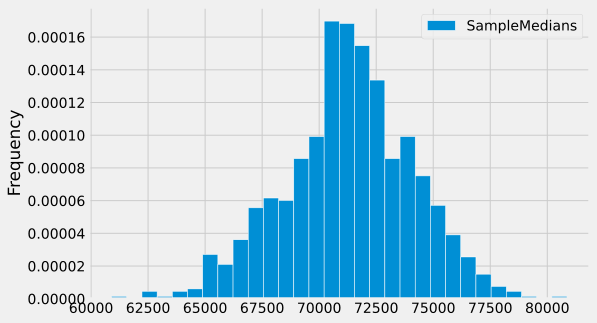

In [52]:
(bpd.DataFrame()
 .assign(SampleMedians=sample_medians)
 .plot(kind='hist', density=True,
       bins=30, ec='w', figsize=(8, 5))
);

### The problem

- Drawing new samples like this is impractical.
    - If we were able to do this, why not just collect more data in the first place?
- Often, we can't ask for new samples from the population.
- **Key insight:** our original sample, `my_sample`, looks a lot like the population.
    - Their distributions are similar.

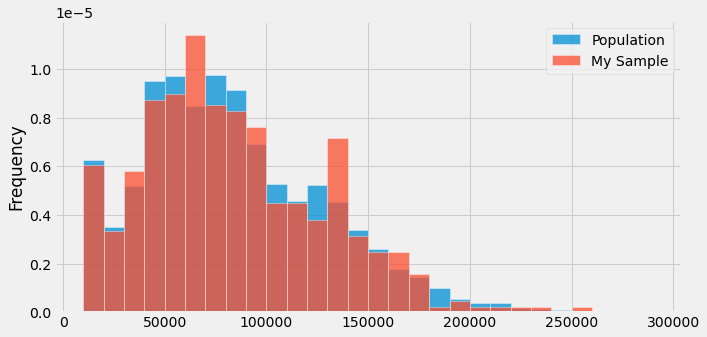

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
bins=np.arange(10_000, 300_000, 10_000)
population.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
my_sample.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
plt.legend(['Population', 'My Sample']);

Note that unlike the previous histogram we saw, this is depicting the distribution of the population and of one particular sample (`my_sample`), **not** the distribution of sample medians for 246 samples.

### The bootstrap

- **Big idea:** Use the sample to simulate more samples.
    - The sample itself looks like the population.
    - So, resampling from the sample is like sampling from the population.
    - The act of resampling from a sample is called **bootstrapping** or "**the bootstrap**" method.

- In our case specifically:
    - We have a sample of 500 salaries.
    - We want another sample of 500 salaries, but we can't draw from the population.
    - However, the original sample looks like the population.
    - So, let's just **resample from the sample!**

In [36]:
show_bootstrapping_slides()

### Resampling with replacement

When bootstrapping, we resample **with** replacement. Why? 🤔

### Resampling with replacement

- Our goal when bootstrapping is to create a sample of the same size as our original sample.
- If we were to resample without replacement $n$ times from an original sample of size $n$, our resample would look exactly the same as the original sample.
    - For instance, if we sample 5 elements without replacement from `['A', 'B', 'C', 'D', 'E']`, our sample will contain the same 5 characters, just in a different order.
- So, we need to sample **with replacement** to ensure that our resamples can be different from the original sample.
- Why does this work? If we assume population is large, sampling with replacement is approx the same as sampling without replacement.

### Running the bootstrap

- We can simulate the act of collecting new samples by **sampling with replacement from our original sample, `my_sample`**.

In [37]:
# Note that the population DataFrame doesn't appear anywhere here!

n_resamples = 5000
boot_medians = np.array([])

for i in range(n_resamples):
    
    # Resample from my_sample WITH REPLACEMENT
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians
    boot_medians = np.append(boot_medians, median)

In [38]:
boot_medians

array([66216. , 67271. , 66471. , ..., 65961. , 69843. , 73182.5])

### Bootstrap distribution of the sample median

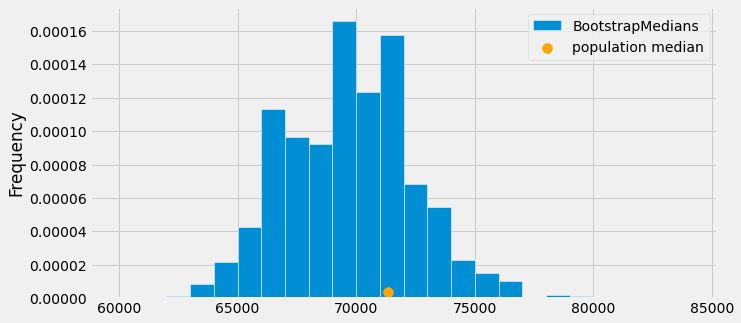

In [39]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

- The population median (orange dot) is near the middle.
    - **In reality, we'd never get to see this!**

### Bootstrap rules of thumb

- The bootstrap is an awesome tool:
    - We only had to collect a single sample from the population to get the (approximate) distribution of the sample median.
- But it has limitations:
    - It is not good for sensitive statistics, like the max or min.
    - It requires the sample to be a good approximation of population.
        - If our original sample was not representative of the population, the resulting bootstrapped samples will also not be representative of the population.

### Example: estimating the max of a population

Suppose we want to estimate the maximum salary of all San Diego city employees, given just a single sample `my_sample`.

In [40]:
# The true maximum salary in the population
population_max = population.get('TotalWages').max()
population_max

320699

### Running the bootstrap

- We want to estimate the maximum number in the population.
- Our estimate will be the max in the sample.
- We run the bootstrap:

In [41]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):

    resample = my_sample.sample(my_sample.shape[0], replace=True)
    
    boot_max = resample.get('TotalWages').max()
    
    boot_maxes = np.append(boot_maxes, boot_max)

In [42]:
boot_maxes

array([230087., 214389., 227311., ..., 230087., 257062., 257062.])

### Visualize

The bootstrap distribution doesn't capture the population maximum (orange dot) of 320699. Why not? 🤔

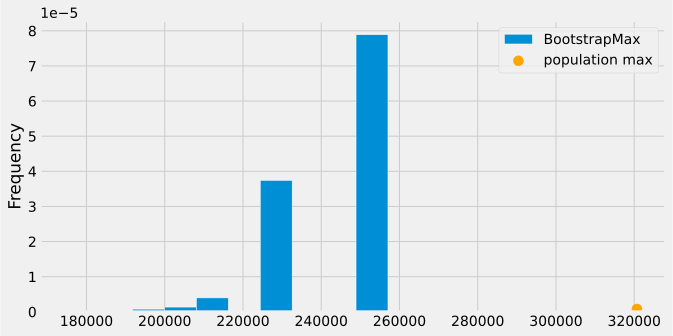

In [55]:
bpd.DataFrame().assign(BootstrapMax=boot_maxes).plot(kind='hist', 
                                                     density=True, 
                                                     bins=10,
                                                     ec='w',
                                                     figsize=(10, 5))
plt.scatter(population_max, 0.0000008, color='orange', s=100, label='population max')
plt.legend();

### Why did that happen?

In [44]:
my_sample.get('TotalWages').max()

257062

- The largest value in our original sample was 257062. 
- Therefore, the largest value in any bootstrapped sample is at most 257062.
- Generally, the bootstrap works better for measures of central tendency or variation (means, medians, variances) than it does for extremas (maxes and mins).

## What's the bootstrap useful for?

- We have a sample median wage:

In [57]:
my_sample.get('TotalWages').median()

69616.0

- And now we can say: the population median wage is approx \\$69616.
    - But how approximate?

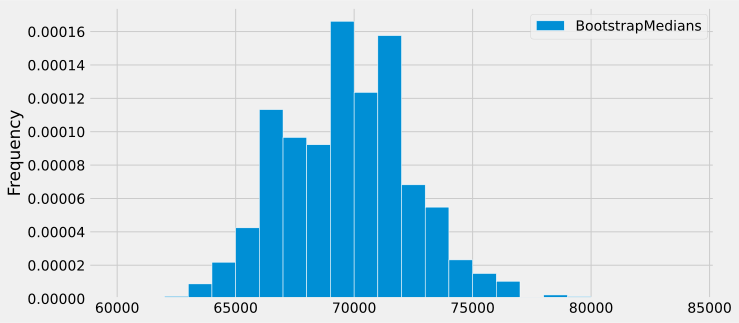

In [59]:
(bpd.DataFrame()
 .assign(BootstrapMedians=boot_medians)
 .plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
)
# plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

- So now we can say: my guess for the population median wage is that it's between \\$65,000 and \\$75,000.
- Next time, we'll talk about how to set this range precisely.

## Why does it matter?

- Now, we're learning estimation techniques that are more applicable to real life.
- Real life: no population, only a sample!
- Using the bootstrap lets us **quantify uncertainty**.
    - With one sample, I might think population median wage is between \\$65,000 and \\$75,000.
    - With another, I might think it's between \\$68,000 and \\$71,000.
    - In the second case, I'm more certain about my estimate.
- Next time: we'll make this rigorous and say exactly what uncertainty means.